# 可以用kernels直接做模型参数调整的
### 特征问题了，晚上就做一件事把，利用训练样本进行拟合，把年龄补充好，可以train+test的所有年龄一起放进
### RF拟合啊， 拟合完以后用SVC，xgb,训练一下，然后做出结果
### 明天晚上看最终的模型，就是进一步特征提取

### 想想为什么随机森林效果很差（树少了）
### 可以直接在kernel上做啊
明天上午做的事情，来调参，借助grid，以及用xgboost做一下，用bayes做一下模型

In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#导入必要的包
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV

In [2]:
#常用模型
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
y_train = df['Survived']  #训练集的label

In [3]:
'''
画图显示中文
'''
#-*- coding: utf-8 -*-
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


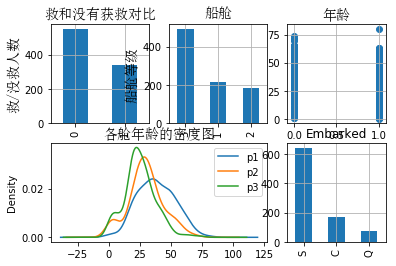

In [5]:
#用图表分析一波
fig = plt.figure()
fig.set(alpha = 0.2)

plt.subplot2grid((2, 3), (0, 0))
df.Survived.value_counts().plot(kind = 'bar')
plt.ylabel('救/没救人数',fontproperties=font)
plt.title(u'救和没有获救对比', fontproperties=font)
plt.grid(True)

plt.subplot2grid((2, 3), (0, 1))
df.Pclass.value_counts().plot(kind = 'bar')
plt.ylabel('船舱等级',fontproperties=font)
plt.title('船舱', fontproperties=font)
plt.grid(True)

plt.subplot2grid((2, 3), (0, 2))
plt.scatter(df.Survived, df.Age)
plt.grid(True)
plt.title('年龄',fontproperties=font)

plt.subplot2grid((2, 3), (1, 0), colspan=2)  #占举两格
df['Age'][df['Pclass'] == 1].plot(kind = 'kde', label = 'p1')
df['Age'][df['Pclass'] == 2].plot(kind = 'kde', label = 'p2')
df['Age'][df['Pclass'] == 3].plot(kind = 'kde', label = 'p3')
plt.legend(loc = 'best')
plt.title(u'各舱年龄的密度图',  fontproperties=font)

plt.subplot2grid((2, 3), (1, 2))
df.Embarked.value_counts().plot(kind = 'bar')
plt.title('Embarked')
plt.grid(True)

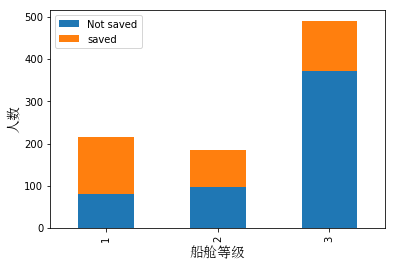

In [27]:
fig = plt.figure()
fig.set(alpha = 0.2)

Survived_0 = df.Pclass[df.Survived == 0].value_counts()
Survived_1 = df.Pclass[df.Survived == 1].value_counts()
plot_df = pd.DataFrame({'saved':Survived_1, 'Not saved':Survived_0})

plot_df.plot(kind = 'bar', stacked = True)
plt.xlabel(u'船舱等级', fontproperties = font)
plt.ylabel(u'人数', fontproperties = font)
plt.legend(loc = 'best')


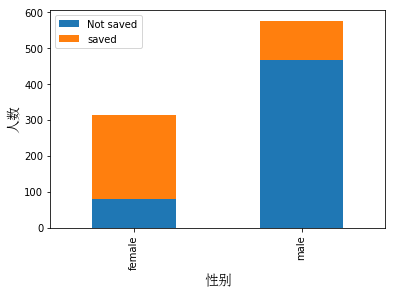

In [28]:
fig = plt.figure()
fig.set(alpha = 0.2)

Survived_0 = df.Sex[df.Survived == 0].value_counts()
Survived_1 = df.Sex[df.Survived == 1].value_counts()
plot_df = pd.DataFrame({'saved':Survived_1, 'Not saved':Survived_0})

plot_df.plot(kind = 'bar', stacked = True)
plt.xlabel(u'性别', fontproperties = font)
plt.ylabel(u'人数', fontproperties = font)
plt.legend(loc = 'best')


(0.0, 500)

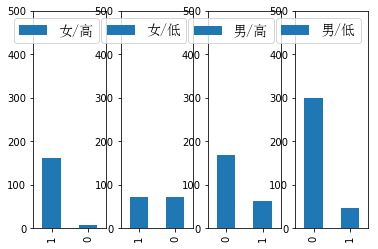

In [35]:
fig = plt.figure()
fig.set(alpha = 0.2)
#plt.title(u'根据各舱和性别的对别分析', fontproperties = font)

ax1 = fig.add_subplot(141)
df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts().plot(kind = 'bar', label = u'女/高')
ax1.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

ax2 = fig.add_subplot(142)
df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts().plot(kind = 'bar', label = u'女/低')
ax2.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

ax3 = fig.add_subplot(143)
df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts().plot(kind = 'bar', label = u'男/高')
ax3.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

ax4 = fig.add_subplot(144)
df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts().plot(kind = 'bar', label = u'男/低')
ax4.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

(0.0, 500)

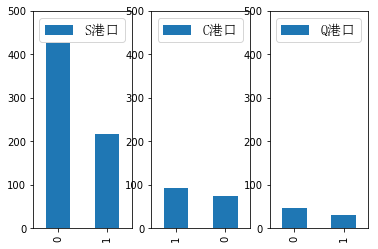

In [61]:
fig = plt.figure()
fig.set(alpha = 0.2)
#plt.title(u'根据各舱和性别的对别分析', fontproperties = font)

ax1 = fig.add_subplot(131)
df.Survived[df.Embarked == 'S'].value_counts().plot(kind = 'bar', label = u'S港口')
ax1.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

ax2 = fig.add_subplot(132)
df.Survived[df.Embarked == 'C'].value_counts().plot(kind = 'bar', label = u'C港口')
ax2.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

ax3 = fig.add_subplot(133)
df.Survived[df.Embarked == 'Q'].value_counts().plot(kind = 'bar', label = u'Q港口')
ax3.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

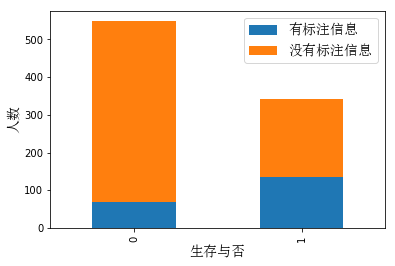

In [72]:
fig = plt.figure()
fig.set(alpha = 0.2)

Cabin_null = df.Survived[df.Cabin.isnull()].value_counts()
Cabin_notnull = df.Survived[df.Cabin.notnull()].value_counts()
df_plot = pd.DataFrame({'没有标注信息':Cabin_null, '有标注信息':Cabin_notnull})

df_plot.plot(kind = 'bar', stacked = True)
plt.xlabel(u'生存与否', fontproperties = font)
plt.ylabel(u'人数', fontproperties = font)
plt.legend(loc = 'best', prop = font)


In [63]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
g = pd.DataFrame(df.groupby(['Parch', 'Survived']).count())
h = pd.DataFrame(df.groupby(['SibSp', 'Survived']).count())

In [52]:
df.Age[df.Survived == 0].mean()
df.Age[df.Survived == 1].mean()

30.62617924528302

In [4]:
df.head()
df_copy = df   #df是原始数据，不要打乱，新建备份来做

In [7]:
df_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#导入必要的包
from sklearn.preprocessing import StandardScaler

In [6]:
#分析完图表以后，开始做训练集
#先对Fare归一化
scaler = StandardScaler()
df_copy['fare_scaled'] = scaler.fit_transform(np.array(df_copy['Fare'].values.reshape(-1, 1)))
df_copy.drop('Fare',axis=1, inplace=True)

In [7]:
#先将Sex和Pclass构造一个组合特征
df_copy['Sex_Pclass'] = df_copy['Sex'] + '_' + df_copy['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

In [8]:
df_copy.loc[ (df_copy.Cabin.notnull()), 'Cabin' ] = "Yes"
df_copy.loc[ (df_copy.Cabin.isnull()), 'Cabin' ] = "No"

In [9]:
df_copy.loc[ (df_copy.Embarked == 'S'), 'Embarked' ] = "S"
df_copy.loc[ (df_copy.Embarked != 'S'), 'Embarked' ] = "other"

In [10]:
df_copy.loc[(df_copy.SibSp != 0), 'SibSp'] = 1
df_copy.loc[(df_copy.SibSp == 0), 'SibSp'] = 0
df_copy.loc[(df_copy.Parch != 0), 'Parch'] = 1
df_copy.loc[(df_copy.Parch == 0), 'Parch'] = 0

In [11]:
#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_copy['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_copy['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_copy['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_copy['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_copy['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_copy['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_copy['Sex_Pclass'], prefix= 'Sex_Pclass')

df_copy = pd.concat([df_copy, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_copy.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)



In [12]:
df_copy.drop(['Name', 'Ticket'], axis = 1, inplace = True)

In [13]:
df_copy.head()

,PassengerId,Survived,Age,fare_scaled,Cabin_No,Cabin_Yes,Parch_0,Parch_1,SibSp_0,SibSp_1,...,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,1,0,22.0,-0.502445,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1
1,2,1,38.0,0.786845,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,3,1,26.0,-0.488854,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,4,1,35.0,0.420730,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,5,0,35.0,-0.486337,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1


In [13]:
#age目前还没有解决
#用中位数填充缺失值
df_copy['Age_fill'] = df_copy.Age.fillna(df_copy.Age.mean())

In [14]:
scaler = StandardScaler()
df_copy['Age_fill_scaled'] = scaler.fit_transform(np.array(df_copy['Age_fill'].values.reshape(-1, 1)))
df_copy.drop(['Age_fill', 'Age'],axis=1, inplace=True)

In [25]:
df_copy.head()

,PassengerId,Survived,fare_scaled,Cabin_No,Cabin_Yes,Parch_0,Parch_1,SibSp_0,SibSp_1,Embarked_S,...,Pclass_1,Pclass_2,Pclass_3,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3,Age_fill_scaled
0,1,0,-0.502445,1,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,1,-0.592481
1,2,1,0.786845,0,1,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0.638789
2,3,1,-0.488854,1,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,0,-0.284663
3,4,1,0.420730,0,1,1,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0.407926
4,5,0,-0.486337,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0.407926


In [15]:
# 我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模
from sklearn import linear_model

train_df = df_copy.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]
    

In [29]:
# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-4)
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:

pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

,coef,columns
0,[-0.0103018563714],fare_scaled
1,[-0.443133948198],Cabin_No
2,[0.58663877047],Cabin_Yes
3,[0.141109579961],Parch_0
4,[0.00239524231138],Parch_1
5,[0.125061098994],SibSp_0
6,[0.0184437232783],SibSp_1
7,[-0.240711987895],Embarked_S
8,[0.384216810167],Embarked_other
9,[1.25335109239],Sex_female


In [33]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [16]:
#对测试集做同样的事情
#分析完图表以后，开始做训练集
#先对Fare归一化
df_test = pd.read_csv('data/test.csv')

scaler = StandardScaler()
df_test['Fare'] = df_test.Fare.fillna(df_test.Fare.mean())
df_test['fare_scaled'] = scaler.fit_transform(np.array(df_test['Fare'].values.reshape(-1, 1)))
df_test.drop('Fare',axis=1, inplace=True)

#先将Sex和Pclass构造一个组合特征
df_test['Sex_Pclass'] = df_test['Sex'] + '_' + df_test['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

df_test.loc[ (df_test.Cabin.notnull()), 'Cabin' ] = "Yes"
df_test.loc[ (df_test.Cabin.isnull()), 'Cabin' ] = "No"

df_test.loc[ (df_test.Embarked == 'S'), 'Embarked' ] = "S"
df_test.loc[ (df_test.Embarked != 'S'), 'Embarked' ] = "other"

df_test.loc[(df_test.SibSp != 0), 'SibSp'] = 1
df_test.loc[(df_test.SibSp == 0), 'SibSp'] = 0
df_test.loc[(df_test.Parch != 0), 'Parch'] = 1
df_test.loc[(df_test.Parch == 0), 'Parch'] = 0

#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_test['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_test['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_test['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_test['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_test['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_test['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_test['Sex_Pclass'], prefix= 'Sex_Pclass')

df_test = pd.concat([df_test, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_test.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)

df_test.drop(['Name', 'Ticket'], axis = 1, inplace = True)

#age目前还没有解决
#用中位数填充缺失值
df_test['Age_fill'] = df_test.Age.fillna(df_test.Age.mean())

scaler = StandardScaler()
df_test['Age_fill_scaled'] = scaler.fit_transform(np.array(df_test['Age_fill'].values.reshape(-1, 1)))
df_test.drop(['Age_fill', 'Age'],axis=1, inplace=True)


In [17]:
test_df = df_test.filter(regex='Age_.*|SibSp_.*|Parch_.*|fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
test_np = test_df.as_matrix()

In [42]:
#预测值
predict_test = clf.predict(test_np)

In [43]:
predict_test = clf.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("logistic_regression_predictions.csv", index=False)  #

In [74]:
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

#plot_learning_curve(clf, u"学习曲线", X, y)

D:\ANACONDA\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ANACONDA\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [26]:
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


#clf = linear_model.LogisticRegression(penalty = 'l2', tol = 1e-4)
#clf = RandomForestRegressor(n_estimators=100, random_state = 0, max_depth = None)
#clf = svm.SVC()
clf = DecisionTreeClassifier()
#clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8)
    
#trainModel = clf.fit(X, y)
#cross_val_score(clf, X, y, cv=5)
clf.fit(X, y)
#clf.score(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
print(cross_val_score(clf, X, y, cv=5))

[ 0.73184358  0.77094972  0.80898876  0.74719101  0.84180791]


In [26]:
clf.score(X, y)

0.98653198653198648

In [30]:
predict_test = clf.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/DT_predictions.csv", index=False)  #

### 用xgboost来做，模型的参数是gridsearchCV做的

In [18]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [19]:
xgb1 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=400,
        max_depth=8,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=1,
        scale_pos_weight=1,
        seed=27)

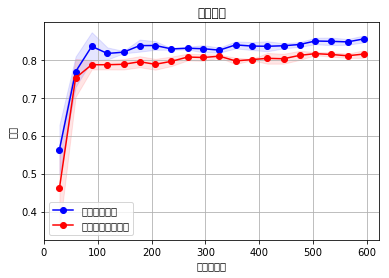

(0.83435633689608435, 0.058907423211535193)

In [32]:
plot_learning_curve(xgb1, u"学习曲线", X, y)

In [20]:
xgb1.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.2, learning_rate=0.01,
       max_delta_step=0, max_depth=8, min_child_weight=5, missing=None,
       n_estimators=400, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.7)

In [24]:
predict_test = xgb1.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/xgb_predictions.csv", index=False)  #

In [27]:
svc1 = svm.SVC(C=0.1, kernel='rbf', degree=3, gamma='auto',random_state=34)
svc1.fit(X, y)
predict_test = svc1.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/svc1_predictions.csv", index=False)  #

In [84]:
df_bayes = pd.read_csv('data/train.csv')
df_bayes.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

(0.0, 500)

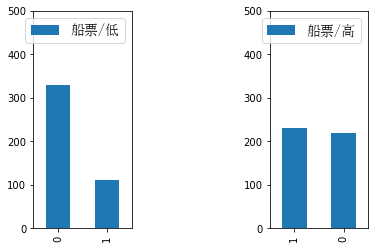

In [46]:
#画个图看一下年龄和船票应该怎么切分

fig = plt.figure()
fig.set(alpha = 0.2)
#plt.title(u'根据各舱和性别的对别分析', fontproperties = font)

ax1 = fig.add_subplot(131)
df_bayes.Survived[df_bayes.Fare <= 14.45].value_counts().plot(kind = 'bar', label = u'船票/低')
ax1.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)

# ax2 = fig.add_subplot(132)
# df_bayes.Survived[df_bayes.Fare <= 100][df_bayes.Fare > 31].value_counts().plot(kind = 'bar', label = u'船票/中')
# ax2.legend(loc = 'best',  prop =  font)
# plt.ylim(ymax=500)

ax3 = fig.add_subplot(133)
df_bayes.Survived[df_bayes.Fare > 14.45].value_counts().plot(kind = 'bar', label = u'船票/高')
ax3.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=500)


In [85]:
#用中位数填充缺失值
df_bayes['Age_fill'] = df_bayes.Age.fillna(df_bayes.Age.median())

In [86]:
df_bayes['Age_fill'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age_fill, dtype: float64

(0.0, 700)

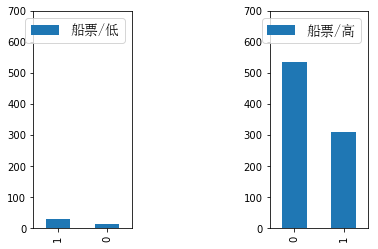

In [107]:
#画个图看一下年龄和年龄应该怎么切分

fig = plt.figure()
fig.set(alpha = 0.2)
#plt.title(u'根据各舱和性别的对别分析', fontproperties = font)

ax1 = fig.add_subplot(131)
df_bayes.Survived[df_bayes.Age_fill <= 5].value_counts().plot(kind = 'bar', label = u'船票/低')
ax1.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=700)

# ax2 = fig.add_subplot(132)
# df_bayes.Survived[df_bayes.Age_fill <= 63][df_bayes.Age_fill > 5].value_counts().plot(kind = 'bar', label = u'船票/中')
# ax2.legend(loc = 'best',  prop =  font)
# plt.ylim(ymax=700)

ax3 = fig.add_subplot(133)
df_bayes.Survived[df_bayes.Age_fill > 5].value_counts().plot(kind = 'bar', label = u'船票/高')
ax3.legend(loc = 'best',  prop =  font)
plt.ylim(ymax=700)


In [121]:
df_bayes = pd.read_csv('data/train.csv')

#用中位数填充缺失值
df_bayes['Age_fill'] = df_bayes.Age.fillna(df_bayes.Age.median())

In [122]:
df_bayes.loc[ (df_bayes.Fare <= 14.45), 'Fare' ] = 1
df_bayes.loc[ (df_bayes.Fare > 14.45), 'Fare' ] = 0

In [123]:
df_bayes.loc[ (df_bayes.Age_fill <= 5), 'Age_fill' ] = 1
df_bayes.loc[ (df_bayes.Age_fill > 63), 'Age_fill' ] = 3
df_bayes.loc[ (df_bayes.Age_fill > 5 ), 'Age_fill' ] = 2

df_bayes.drop('Age',axis=1, inplace=True)


In [116]:
df_bayes.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_fill
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,1.0,NaN,S,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,0.0,C85,C,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,1.0,NaN,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,0.0,C123,S,2.0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,1.0,NaN,S,2.0


In [125]:
#用Bayes做一下


#先将Sex和Pclass构造一个组合特征
df_bayes['Sex_Pclass'] = df_bayes['Sex'] + '_' + df_bayes['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

df_bayes.loc[ (df_bayes.Cabin.notnull()), 'Cabin' ] = 1
df_bayes.loc[ (df_bayes.Cabin.isnull()), 'Cabin' ] = 0

df_bayes.loc[ (df_bayes.Embarked != 'S'), 'Embarked' ] = 0
df_bayes.loc[ (df_bayes.Embarked == 'S'), 'Embarked' ] = 1

df_bayes.loc[(df_bayes.SibSp != 0), 'SibSp'] = 1
df_bayes.loc[(df_bayes.SibSp == 0), 'SibSp'] = 0
df_bayes.loc[(df_bayes.Parch != 0), 'Parch'] = 1
df_bayes.loc[(df_bayes.Parch == 0), 'Parch'] = 0

#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_bayes['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_bayes['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_bayes['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_bayes['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_bayes['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_bayes['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_bayes['Sex_Pclass'], prefix= 'Sex_Pclass')

df_bayes = pd.concat([df_bayes, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_bayes.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)

df_bayes.drop(['Name', 'Ticket'], axis = 1, inplace = True)



In [127]:
df_bayes.head()

,PassengerId,Survived,Fare,Age_fill,Cabin_0,Cabin_1,Parch_0,Parch_1,SibSp_0,SibSp_1,...,Sex_male,Pclass_1,Pclass_2,Pclass_3,Sex_Pclass_female_1,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,1,0,1.0,2.0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1
1,2,1,0.0,2.0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,3,1,1.0,2.0,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,4,1,0.0,2.0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,5,0,1.0,2.0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1


In [136]:
# 我们把需要的feature字段取出来，转成numpy格式

train_df = df_bayes.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]
    

In [139]:
#用NB做
from sklearn.naive_bayes import MultinomialNB

In [140]:
nb = MultinomialNB()
nb.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [150]:
print(cross_val_score(nb, X, y, cv=5))

[ 0.68156425  0.77094972  0.78651685  0.76966292  0.80225989]


In [144]:
df_bayes = pd.read_csv('data/test.csv')

df_bayes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [148]:
#对test做相应处理
#用Bayes做一下
df_bayes = pd.read_csv('data/test.csv')

#用中位数填充缺失值
df_bayes['Age_fill'] = df_bayes.Age.fillna(df_bayes.Age.median())
df_bayes['Fare'] = df_bayes.Fare.fillna(df_bayes.Fare.mean())
df_bayes.loc[ (df_bayes.Fare <= 14.45), 'Fare' ] = 1
df_bayes.loc[ (df_bayes.Fare > 14.45), 'Fare' ] = 0
df_bayes.loc[ (df_bayes.Age_fill <= 5), 'Age_fill' ] = 1
df_bayes.loc[ (df_bayes.Age_fill > 63), 'Age_fill' ] = 3
df_bayes.loc[ (df_bayes.Age_fill > 5 ), 'Age_fill' ] = 2

df_bayes.drop('Age',axis=1, inplace=True)

#先将Sex和Pclass构造一个组合特征
df_bayes['Sex_Pclass'] = df_bayes['Sex'] + '_' + df_bayes['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

df_bayes.loc[ (df_bayes.Cabin.notnull()), 'Cabin' ] = 1
df_bayes.loc[ (df_bayes.Cabin.isnull()), 'Cabin' ] = 0

df_bayes.loc[ (df_bayes.Embarked != 'S'), 'Embarked' ] = 0
df_bayes.loc[ (df_bayes.Embarked == 'S'), 'Embarked' ] = 1

df_bayes.loc[(df_bayes.SibSp != 0), 'SibSp'] = 1
df_bayes.loc[(df_bayes.SibSp == 0), 'SibSp'] = 0
df_bayes.loc[(df_bayes.Parch != 0), 'Parch'] = 1
df_bayes.loc[(df_bayes.Parch == 0), 'Parch'] = 0

#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_bayes['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_bayes['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_bayes['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_bayes['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_bayes['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_bayes['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_bayes['Sex_Pclass'], prefix= 'Sex_Pclass')

df_bayes = pd.concat([df_bayes, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_bayes.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)

df_bayes.drop(['Name', 'Ticket'], axis = 1, inplace = True)

test_df = df_bayes.filter(regex='Age_.*|SibSp_.*|Parch_.*|Fare|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
test_np = test_df.as_matrix()

In [151]:
predict_test = nb.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/NB_predictions.csv", index=False)  #

In [57]:
df_train = pd.read_csv('data/train.csv')
df_test= pd.read_csv('data/test.csv')
df_train.Embarked = df_train.Embarked.fillna('S')
df_test['Fare'] = df_test.Fare.fillna(df_test.Fare.mean())

In [58]:
train_df =  df_train[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
test_df =  df_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

In [59]:
age_all = pd.concat((train_df, test_df), axis = 0)

In [60]:
age_train = age_all[age_all.Age.notnull()].as_matrix()
age_test_null = test_df[test_df.Age.isnull()].as_matrix()
age_train_null = train_df[train_df.Age.isnull()].as_matrix()

y = age_train[:, 0]
X = age_train[:, 1:]

In [34]:
from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(X, y):

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(age_train_null[:, 1:])
    
    # 用得到的预测结果填补原缺失数据
    df_train.loc[ (df_train.Age.isnull()), 'Age' ] = predictedAges
    
    return df_train, rfr

In [61]:
df_train, rfr = set_missing_ages(X, y)

In [62]:
# 用得到的模型进行未知年龄结果预测
predictedAges = rfr.predict(age_test_null[:, 1:])
    
# 用得到的预测结果填补原缺失数据
df_test.loc[ (df_test.Age.isnull()), 'Age' ] = predictedAges

In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [66]:
#先对Fare归一化

scaler = StandardScaler()
df_train['fare_scaled'] = scaler.fit_transform(np.array(df_train['Fare'].values.reshape(-1, 1)))
df_train.drop('Fare',axis=1, inplace=True)

#先将Sex和Pclass构造一个组合特征
df_train['Sex_Pclass'] = df_train['Sex'] + '_' + df_train['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

df_train.loc[ (df_train.Cabin.notnull()), 'Cabin' ] = "Yes"
df_train.loc[ (df_train.Cabin.isnull()), 'Cabin' ] = "No"

df_train.loc[ (df_train.Embarked == 'S'), 'Embarked' ] = "S"
df_train.loc[ (df_train.Embarked != 'S'), 'Embarked' ] = "other"

df_train.loc[(df_train.SibSp != 0), 'SibSp'] = 1
df_train.loc[(df_train.SibSp == 0), 'SibSp'] = 0
df_train.loc[(df_train.Parch != 0), 'Parch'] = 1
df_train.loc[(df_train.Parch == 0), 'Parch'] = 0

#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_train['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_train['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_train['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_train['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_train['Sex_Pclass'], prefix= 'Sex_Pclass')

df_train = pd.concat([df_train, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_train.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)

df_train.drop(['Name', 'Ticket'], axis = 1, inplace = True)

#age
scaler = StandardScaler()
df_train['Age_fill_scaled'] = scaler.fit_transform(np.array(df_train['Age'].values.reshape(-1, 1)))
df_train.drop(['Age'],axis=1, inplace=True)


In [75]:
# 我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模

train_x = df_train.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_x.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]
    

In [92]:

svc1 = svm.SVC(C=1.5, kernel='rbf', degree=3, gamma='auto',random_state=34)
svc1.fit(X, y)
print(cross_val_score(svc1, X, y, cv=5))
# predict_test = svc1.predict(test_np)
# result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
# #写成标准的数据上传格式

# result.to_csv("pred_label/svc1_predictions.csv", index=False)  #

[ 0.82681564  0.81005587  0.82022472  0.80337079  0.81920904]


In [94]:
#对测试集做同样的事情
#分析完图表以后，开始做训练集
#先对Fare归一化

scaler = StandardScaler()
df_test['fare_scaled'] = scaler.fit_transform(np.array(df_test['Fare'].values.reshape(-1, 1)))
df_test.drop('Fare',axis=1, inplace=True)

#先将Sex和Pclass构造一个组合特征
df_test['Sex_Pclass'] = df_test['Sex'] + '_' + df_test['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性

df_test.loc[ (df_test.Cabin.notnull()), 'Cabin' ] = "Yes"
df_test.loc[ (df_test.Cabin.isnull()), 'Cabin' ] = "No"

df_test.loc[ (df_test.Embarked == 'S'), 'Embarked' ] = "S"
df_test.loc[ (df_test.Embarked != 'S'), 'Embarked' ] = "other"

df_test.loc[(df_test.SibSp != 0), 'SibSp'] = 1
df_test.loc[(df_test.SibSp == 0), 'SibSp'] = 0
df_test.loc[(df_test.Parch != 0), 'Parch'] = 1
df_test.loc[(df_test.Parch == 0), 'Parch'] = 0

#对于年龄来说，存在缺失值，稍后做
#先将Sex和Pclass转换成one-hot，并且构造一个组合特征
dummies_Cabin = pd.get_dummies(df_test['Cabin'], prefix= 'Cabin')

dummies_Parch = pd.get_dummies(df_test['Parch'], prefix= 'Parch')

dummies_SibSp = pd.get_dummies(df_test['SibSp'], prefix= 'SibSp')

dummies_Embarked = pd.get_dummies(df_test['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(df_test['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(df_test['Pclass'], prefix= 'Pclass')

dummies_Sex_Pclass = pd.get_dummies(df_test['Sex_Pclass'], prefix= 'Sex_Pclass')

df_test = pd.concat([df_test, dummies_Cabin, dummies_Parch, dummies_SibSp,\
                     dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_test.drop(['Pclass', 'Sex', 'Cabin', 'Embarked', 'Sex_Pclass', 'Parch', 'SibSp'], axis=1, inplace=True)

df_test.drop(['Name', 'Ticket'], axis = 1, inplace = True)

#age
scaler = StandardScaler()
df_test['Age_fill_scaled'] = scaler.fit_transform(np.array(df_test['Age'].values.reshape(-1, 1)))
df_test.drop(['Age'],axis=1, inplace=True)


In [95]:
test_x = df_test.filter(regex='Age_.*|SibSp_.*|Parch_.*|fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
test_np = test_x.as_matrix()

In [97]:
predict_test = svc1.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式
result.to_csv("pred_label/svc1_new_predictions.csv", index=False)  

In [102]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=500,
        max_depth=6,
        min_child_weight=5,
        gamma=0.0,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        objective= 'binary:logistic',
        nthread=1,
        scale_pos_weight=1,
        seed=27)

In [103]:
xgb4.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
       n_estimators=500, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.9)

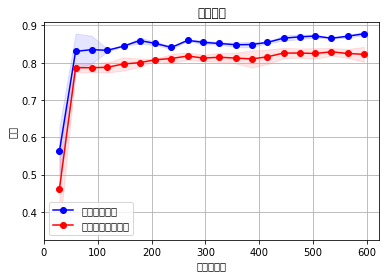

(0.84232413705954245, 0.079081596558297718)

In [106]:
plot_learning_curve(xgb4, u"学习曲线", X, y)

In [107]:
predict_test = xgb4.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/xgb4_predictions.csv", index=False)  #

In [115]:
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-4)

In [120]:
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-4)

from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(clf, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [123]:
bagging_clf.score(X, y)

0.81369248035914699

In [125]:
predict_test = svc1.predict(test_np)
result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式
result.to_csv("pred_label/bagging_clf_predictions.csv", index=False)  

In [130]:
result.Survived.value_counts()

0    288
1    130
Name: Survived, dtype: int64

In [9]:
from patsy import dmatrices
import string
from operator import itemgetter
import json
from sklearn import preprocessing
#清理和处理数据
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

le = preprocessing.LabelEncoder()
enc=preprocessing.OneHotEncoder()

def clean_and_munge_data(df):
    #处理缺省值
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    #处理一下名字，生成Title字段
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))

    #处理特殊的称呼，全处理成mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title

    df['Title']=df.apply(replace_titles, axis=1)

    #看看家族是否够大，咳咳
    df['Family_Size']=df['SibSp']+df['Parch'] + 1
#     df['Family']=df['SibSp']*df['Parch']


    df.loc[ (df.Fare.isnull())&(df.Pclass==1),'Fare'] =np.median(df[df['Pclass'] == 1]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==2),'Fare'] =np.median( df[df['Pclass'] == 2]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==3),'Fare'] = np.median(df[df['Pclass'] == 3]['Fare'].dropna())

    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    df['AgeFill']=df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(df[df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(df[df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(df[df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(df[df['Title'] == 'Master']['Age'].dropna())
    df.loc[ (df.Age.isnull()) & (df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

#     df['AgeCat']=df['AgeFill']
#     df.loc[ (df.AgeFill<=10) ,'AgeCat'] = 'child'
#     df.loc[ (df.AgeFill>60),'AgeCat'] = 'aged'
#     df.loc[ (df.AgeFill>10) & (df.AgeFill <=30) ,'AgeCat'] = 'adult'
#     df.loc[ (df.AgeFill>30) & (df.AgeFill <=60) ,'AgeCat'] = 'senior'

    df.Embarked = df.Embarked.fillna('S')


#     df['Fare_Per_Person']=df['Fare']/df['Family_Size']

#     #Age times class

#     df['AgeClass']=df['AgeFill']*df['Pclass']
#     df['ClassFare']=df['Pclass']*df['Fare_Per_Person']


#     df['HighLow']=df['Pclass']
#     df.loc[ (df.Fare_Per_Person<8) ,'HighLow'] = 'Low'
#     df.loc[ (df.Fare_Per_Person>=8) ,'HighLow'] = 'High'




#     le.fit( df['Ticket'])
#     x_Ticket=le.transform( df['Ticket'])
#     df['Ticket']=x_Ticket.astype(np.float)

#     le.fit(df['Title'])
#     x_title=le.transform(df['Title'])
#     df['Title'] =x_title.astype(np.float)

#     le.fit(df['HighLow'])
#     x_hl=le.transform(df['HighLow'])
#     df['HighLow']=x_hl.astype(np.float)


#     le.fit(df['AgeCat'])
#     x_age=le.transform(df['AgeCat'])
#     df['AgeCat'] =x_age.astype(np.float)


    df = df.drop(['PassengerId','Name','Age'], axis=1) #remove Name,Age and PassengerId


    return df

In [3]:
df_train = pd.read_csv('data/train.csv')

In [4]:
df_test = pd.read_csv('data/test.csv')

In [35]:
data_df = df_train.append(df_test)

In [36]:

data_df = clean_and_munge_data(data_df)  #合并训练数据和测试数据

In [37]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Family_Size    1309 non-null int64
Gender         1309 non-null int32
AgeFill        1309 non-null float64
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 138.1+ KB


In [38]:
#df = df_train.filter(regex='Survived|SibSp|Family_Size|Parch|Family|Title|Fare|AgeCat|AgeFill|HighLow|Fare_Per_Person||Embarked|Sex|Pclass')

data_df.drop(['Ticket', 'Title'], axis=1,inplace = True) #remove Name,Age and PassengerId

In [39]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Family_Size    1309 non-null int64
Gender         1309 non-null int32
AgeFill        1309 non-null float64
dtypes: float64(3), int32(1), int64(4), object(3)
memory usage: 117.6+ KB


In [32]:
def process_data(df_train):
    #先对Fare归一化

    scaler = StandardScaler()
    df_train['fare_scaled'] = scaler.fit_transform(np.array(df_train['Fare'].values.reshape(-1, 1)))
    df_train.drop('Fare',axis=1, inplace=True)

#     scaler = StandardScaler()
#     df_train['fare_person_scaled'] = scaler.fit_transform(np.array(df_train['Fare_Per_Person'].values.reshape(-1, 1)))
#     df_train.drop('Fare_Per_Person',axis=1, inplace=True)

    scaler = StandardScaler()
    df_train['family_scaled'] = scaler.fit_transform(np.array(df_train['Family_Size'].values.reshape(-1, 1)))
    df_train.drop('Family_Size',axis=1, inplace=True)


    
    #先将Sex和Pclass构造一个组合特征
        
    le = preprocessing.LabelEncoder()
    scaler = StandardScaler()
    df_train['Sex_Pclass'] = df_train['Sex'] + '_' + df_train['Pclass'].map(str)  #将性别和Pclass单独组合起来成为一个新的属性
    df_train['Sex_Pclass'] = le.fit_transform(df_train['Sex_Pclass'])
    df_train['Sex_Pclass'] = scaler.fit_transform(np.array(df_train['Sex_Pclass'].values.reshape(-1, 1)))
    
    scaler = StandardScaler()
    df_train['Pclass'] = scaler.fit_transform(np.array(df_train['Pclass'].values.reshape(-1, 1)))
    
    le = preprocessing.LabelEncoder()
    df_train.loc[ (df_train.Cabin.notnull()), 'Cabin' ] = "Yes"
    df_train.loc[ (df_train.Cabin.isnull()), 'Cabin' ] = "No"
    df_train['Cabin'] = le.fit_transform(df_train['Cabin'])

    le = preprocessing.LabelEncoder()
    df_train.loc[ (df_train.Embarked == 'S'), 'Embarked' ] = "S"
    df_train.loc[ (df_train.Embarked != 'S'), 'Embarked' ] = "other"
    df_train['Embarked'] = le.fit_transform(df_train['Embarked'])
    

#     df_train.loc[(df_train.SibSp != 0), 'SibSp'] = 1
#     df_train.loc[(df_train.SibSp == 0), 'SibSp'] = 0
#     df_train.loc[(df_train.Parch != 0), 'Parch'] = 1
#     df_train.loc[(df_train.Parch == 0), 'Parch'] = 0

    #对于年龄来说，存在缺失值，稍后做
    #先将Sex和Pclass转换成one-hot，并且构造一个组合特征
#     dummies_Cabin = pd.get_dummies(df_train['Cabin'], prefix= 'Cabin')

#     dummies_HighLow = pd.get_dummies(df_train['HighLow'], prefix= 'HighLow')

#     dummies_AgeCat = pd.get_dummies(df_train['AgeCat'], prefix= 'AgeCat')

#     dummies_Parch = pd.get_dummies(df_train['Parch'], prefix= 'Parch')

#     dummies_Title = pd.get_dummies(df_train['Title'], prefix= 'Title')

#     dummies_SibSp = pd.get_dummies(df_train['SibSp'], prefix= 'SibSp')

#     dummies_Embarked = pd.get_dummies(df_train['Embarked'], prefix= 'Embarked')

#     dummies_Sex = pd.get_dummies(df_train['Sex'], prefix= 'Sex')

#     dummies_Pclass = pd.get_dummies(df_train['Pclass'], prefix= 'Pclass')

#     dummies_Sex_Pclass = pd.get_dummies(df_train['Sex_Pclass'], prefix= 'Sex_Pclass')

#     df_train = pd.concat([df_train, dummies_Cabin, dummies_Parch, dummies_SibSp,dummies_HighLow,dummies_Title,dummies_AgeCat,\
#                          dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
    df_train.drop(['Sex', 'Parch', 'SibSp'], axis=1, inplace=True)


    #age
    scaler = StandardScaler()
    df_train['Age_fill_scaled'] = scaler.fit_transform(np.array(df_train['AgeFill'].values.reshape(-1, 1)))
    df_train.drop(['AgeFill'],axis=1, inplace=True)
    
    return df_train


In [40]:
data_df = process_data(data_df)

D:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Cabin              1309 non-null int64
Embarked           1309 non-null int64
Pclass             1309 non-null float64
Survived           891 non-null float64
Gender             1309 non-null int32
fare_scaled        1309 non-null float64
family_scaled      1309 non-null float64
Sex_Pclass         1309 non-null float64
Age_fill_scaled    1309 non-null float64
dtypes: float64(6), int32(1), int64(2)
memory usage: 97.2 KB


In [43]:
df_train = data_df[:891]
df_test = data_df[891:]

In [89]:
sum(df_train['Survived'])

342.0

In [94]:
# 我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模

# train_x = df_train.filter(regex='Survived|Age_.*|Title_.*|AgeCat_.*|fare_person_.*|family_.*|Cabin_.*|Embarked_.*|Sex_.*|HighLow_.*|Pclass_.*')
# train_x = df_train.filter(regex='Survived|Age_fill_.*|family_.*|fare_.*|Cabin|Embarked|Pclass|Gender')

# train_np = train_x.as_matrix()

# # y即Survival结果
# y = df_train['Survived'].as_matrxi()

# # X即特征属性值
# X = train_np[:, 1:]

X = df_train.drop('Survived', 1).as_matrix()
y = df_train['Survived'].as_matrix()

In [99]:
# 我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模

# test_x = df_test.filter(regex='Age_fill_.*|family_.*|fare_.*|Cabin|Embarked|Pclass|Gender')
# # test_x = df_test.filter(regex='Age_.*|Title_.*|SibSp_.*|AgeCat_.*|Parch_.*|fare_.*|family_.*|Cabin_.*|Embarked_.*|Sex_.*|HighLow_.*|Pclass_.*')
# test_np = test_x.as_matrix()

test_np = df_test.drop('Survived', 1).as_matrix()


In [100]:
test_np[:2]

array([[ 0.        ,  1.        ,  0.84191642,  1.        , -0.50077657,
        -0.55834605,  1.01285151,  0.3449312 ],
       [ 0.        ,  0.        ,  0.84191642,  0.        , -0.51682848,
         0.07335229, -0.70083564,  1.2921237 ]])

In [101]:
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-4)

#bagging_clf = BaggingClassifier(clf, n_estimators=10, max_samples=0.7, max_features=0.9, bootstrap=True, bootstrap_features=False, n_jobs=1)
#bagging_clf.fit(X, y)
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
sum(clf.predict(X))

322.0

In [103]:
# print(cross_val_score(bagging_clf, X, y, cv=5))
print(cross_val_score(svc1, X, y, cv=5))

[ 0.84357542  0.81564246  0.81460674  0.79775281  0.86440678]


In [116]:
svc1 = svm.SVC(C=2.0, kernel='rbf', degree=3, gamma='auto',random_state=34)


#bagging_clf = BaggingClassifier(svc1, n_estimators=8, max_samples=0.3, max_features=0.4, bootstrap=True, bootstrap_features=False, n_jobs=1)
#bagging_clf.fit(X, y)
svc1.fit(X, y)
# print(cross_val_score(svc1, X, y, cv=5))
# predict_test = svc1.predict(test_np)
# result = pd.DataFrame({'PassengerId':df_test['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
# #写成标准的数据上传格式

# result.to_csv("pred_label/svc1_predictions.csv", index=False)  #

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=34, shrinking=True,
  tol=0.001, verbose=False)

In [117]:
print(cross_val_score(svc1, X, y, cv=5))

[ 0.84357542  0.81564246  0.81460674  0.79775281  0.86440678]


In [108]:
param_test3 = {
    'n_estimators':[8,10,12,15],
    'max_samples':[i/10.0 for i in range(1,10)],
    'max_features':[i/10.0 for i in range(2,9)]
}
gsearch1 = GridSearchCV(BaggingClassifier(clf, n_estimators=15, max_samples=0.7, max_features=0.8,\
                                          bootstrap=True, bootstrap_features=False, n_jobs=1), 
                       param_grid = param_test3, scoring='accuracy',n_jobs=1,iid=False, cv=5)
gsearch1.fit(X,y)

gsearch1.best_params_, gsearch1.best_score_

({'max_features': 0.4, 'max_samples': 0.3, 'n_estimators': 8},
 0.8114343388348126)

In [118]:
new_id = pd.read_csv('data/test.csv')

predict_test = svc1.predict(test_np)
result = pd.DataFrame({'PassengerId':new_id['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/bagging_clf_predictions.csv", index=False)  #

In [119]:
result.Survived.value_counts()

0    276
1    142
Name: Survived, dtype: int64

In [115]:
param_test3 = {
    'C':[i/2.0 for i in range(1,5)],
    #'C':[1.2,1.3,1.4,1.5,1.6,1.7,1.8]
    'kernel':['poly','rbf','linear']
}
gsearch1 = GridSearchCV(estimator = svm.SVC(C=0.5, kernel='rbf', degree=3, gamma='auto',random_state=34), 
                       param_grid = param_test3, scoring='accuracy',n_jobs=1,iid=False, cv=5)
gsearch1.fit(X,y)

gsearch1.best_params_, gsearch1.best_score_

({'C': 2.0, 'kernel': 'rbf'}, 0.8271968414635573)

In [130]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=1500, max_depth=7,reg_alpha=1,
                                        min_child_weight=1, gamma=0.2, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27)

In [131]:
xgb4.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.2, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1500, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.9)

In [132]:
xgb4.score(X, y)

0.90572390572390571

In [133]:
new_id = pd.read_csv('data/test.csv')

predict_test = xgb4.predict(test_np)
result = pd.DataFrame({'PassengerId':new_id['PassengerId'].as_matrix(), 'Survived':predict_test.astype(np.int32)})
#写成标准的数据上传格式

result.to_csv("pred_label/xgb4_predictions.csv", index=False)  #

In [134]:
result.Survived.value_counts()

0    276
1    142
Name: Survived, dtype: int64

In [129]:
param_test4 = {
#     'n_estimators':[400,500,800,1000,1500]
    #'n_estimators':[350,400,450,500],
    'max_depth':list(range(1,10,2)),
    'min_child_weight':list(range(1,6,2)),
#     'max_depth':[3,4,5,6],
    #'min_child_weight':[2,3,4],
#     'reg_alpha':[0.01,0.1, 0.5, 1],
#     'gamma':[0.0,0.1,0.2]
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)]
    #'subsample':[0.85,0.9,0.95],
    #'colsample_bytree':[0.75,0.8,0.85]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=1500, max_depth=7,reg_alpha=1,
                                        min_child_weight=1, gamma=0.2, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='accuracy',n_jobs=1,iid=False, cv=5)
gsearch1.fit(X,y)

gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 1500}, 0.8418286913160463)